In [2]:
import sparrowpy as sp
import pyfar as pf
import numpy as np
import matplotlib.pyplot as plt
import os
import json

%matplotlib inline


base_dir = "C:\\Users\\jotag\\Documents\\phd\\listening experiment\\synthesis\\lib\\"

In [3]:
# simulation settings
sr_etc = 100
etc_time_resolution = 1/sr_etc
speed_of_sound = 343
max_refl = 40
freqbands = pf.dsp.filter.fractional_octave_frequencies(num_fractions=1)
freqcy = freqbands[0]

In [4]:
with open(os.path.join(base_dir,
                       "Scenario_86",
                       "S86_trajectory.json"))as traj_file:
    trajectory_data = json.load(traj_file)

source_positions = np.array(trajectory_data["v_trajectory"])

distances = np.linalg.norm(source_positions,axis=1)

center = np.argmin(distances)

left = np.argmin((np.array(trajectory_data["v_timestamp"])-
                 (trajectory_data["v_timestamp"][center]-30))**2)
right = np.argmin((np.array(trajectory_data["v_timestamp"])-
                 (trajectory_data["v_timestamp"][center]+30))**2)

source_positions = source_positions[left:right].T
max_duration = np.max(distances[left:right])/speed_of_sound+4


source = pf.Coordinates(0,0,0)
receiver = pf.Coordinates(source_positions[0][0],
                          source_positions[1][0],
                          source_positions[2][0])

In [5]:
#radiosity object from file, whole wall-patch shabang
radi = sp.DirectionalRadiosityFast.from_file(
                filepath=os.path.join(base_dir,"SPatrizia_final.blend"),
                wall_auto_assembly=False,
                geometry_identifier="radi_test",
                )

In [6]:
# load material file
with open(os.path.join(base_dir,
                       "acoustic_materials_RISC.json"))as mat_file:
    material_data = json.load(mat_file)

C:\Users\jotag\AppData\Local\Temp\ipykernel_37468\2894823387.py:2: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  samples = pf.samplings.sph_gaussian(10)
c:\Users\jotag\Documents\dev\sparapy\.venv\Lib\site-packages\pyfar\samplings\samplings.py:344: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  sampling = pyfar.Coordinates(
c:\Users\jotag\Documents\dev\sparapy\.venv\Lib\site-packages\pyfar\classes\coordinates.py:276: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  self.sh_order = sh_order


<Axes3D: xlabel='x in m', ylabel='y in m', zlabel='z in m'>

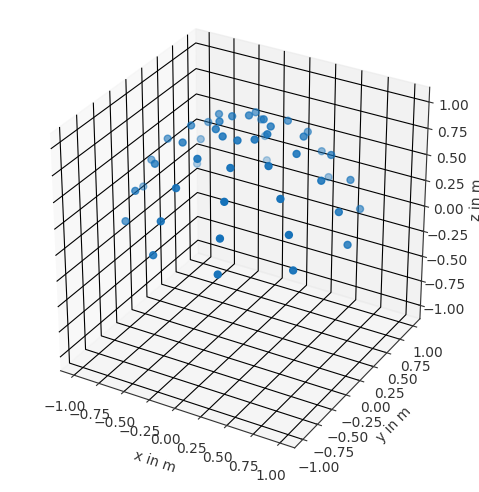

In [7]:
# set brdfs
samples = pf.samplings.sph_gaussian(10)
brdf_sources = samples[np.where((samples.elevation*180/np.pi >= 0))].copy()
brdf_receivers = samples[np.where((samples.elevation*180/np.pi >= 0))].copy()
brdf_sources.show()


In [85]:
# set brdfs
frequencies = np.array([freqcy])

for material_name in material_data.keys():
    brdf = sp.brdf.create_from_scattering(
        brdf_sources,
        brdf_receivers,
        pf.FrequencyData(material_data[material_name]["scattering"],
                         material_data[material_name]["frequency"]),
        pf.FrequencyData(material_data[material_name]["absorption"],
                         material_data[material_name]["frequency"]))

    # set directional scattering data
    radi.set_wall_brdf(
        np.where(radi._walls_material==material_name)[0],
        brdf,
        brdf_sources,
        brdf_receivers)


radi.set_air_attenuation(
    pf.FrequencyData(
        trajectory_data["v_attenuation"],
        frequencies))

radi.bake_geometry()

In [86]:
radi.write(os.path.join(base_dir,"simu_steps","baked_simulation.far"),compress=False)

In [87]:
radi.init_source_energy(source)

radi.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        etc_time_resolution=etc_time_resolution,
        etc_duration=max_duration,
        max_reflection_order=max_refl,
        recalculate=True)

In [88]:
radi.write(os.path.join(base_dir,"simu_steps","exchanged_simulation.far"),compress=True)

In [89]:
for direct_sound in [True,False]:
    etc_radiosity = radi.collect_energy_receiver_mono(
        receivers=receiver,direct_sound=direct_sound)

    if direct_sound:
        mononame = "etc_mono_WITH_direct.far"
    else:
        mononame = "etc_mono_NO_direct.far"

    pf.io.write(os.path.join(base_dir,"etcs",mononame),
                etc_radiosity=etc_radiosity,
                compress=True)

In [91]:

etc_pluri = radi.collect_energy_receiver_patchwise(
receivers=receiver)

# pf.io.write(os.path.join(base_dir,"etcs","etc_pluri.far"),
#         etc_radiosity=etc_radiosity,
#         compress=True)

# pf.io.write(os.path.join(base_dir,"etcs","etc_pluri_nocomp.far"),
#         etc_radiosity=etc_radiosity,
#         compress=False)

In [ ]:
a= etc_pluri
c = pf.io.read(os.path.join(base_dir,"etcs","etc_pluri.far"))["etc_radiosity"]
b = pf.io.read(os.path.join(base_dir,"etcs","etc_pluri_nocomp.far"))["etc_radiosity"]
print(np.max(np.abs(a.time-b.time)))

[[[[-2.36756248e-072 -1.48407097e-072 -8.89896130e-073 ...
    -9.43131339e-072 -5.96527981e-072 -3.76302715e-072]
   [-1.54643222e-072 -9.69236817e-073 -5.81148493e-073 ...
    -6.16279429e-072 -3.89739719e-072 -2.45823019e-072]
   [-2.31981848e-072 -1.45456868e-072 -8.71578957e-073 ...
    -9.22469875e-072 -5.83809931e-072 -3.68493637e-072]
   ...
   [-1.23797285e-075 -7.86448540e-076 -4.69901878e-076 ...
    -4.71783369e-075 -3.02691812e-075 -1.93787191e-075]
   [-1.85899968e-081 -1.19521126e-081 -7.04402839e-082 ...
    -6.76862340e-081 -4.40771346e-081 -2.86511535e-081]
   [-1.51472393e-108 -9.64134309e-109 -5.08502617e-109 ...
    -5.49093828e-108 -3.58077659e-108 -2.33099641e-108]]

  [[-2.36756248e-072 -1.48407097e-072 -8.89896130e-073 ...
    -9.43131339e-072 -5.96527981e-072 -3.76302715e-072]
   [-1.54643222e-072 -9.69236817e-073 -5.81148493e-073 ...
    -6.16279429e-072 -3.89739719e-072 -2.45823019e-072]
   [-2.31981848e-072 -1.45456868e-072 -8.71578957e-073 ...
    -9.22469

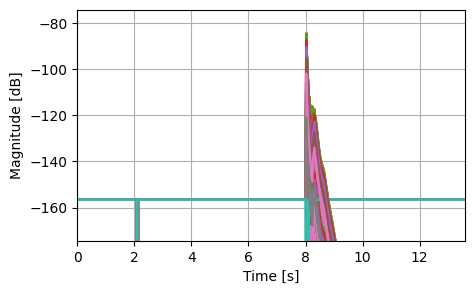

In [ ]:
figure,ax = plt.subplots(figsize=(5,3))
pf.plot.time(signal=kk,dB=True,log_prefix=10, ax=ax,
             linestyle='-',label="first position")

ax.set_ylabel('Magnitude [dB]')
ax.set_xlabel('Time [s]')
plt.grid()

In [ ]:
%load_ext watermark
%watermark -v -m -iv

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.9
IPython version      : 9.1.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 68 Stepping 1, AuthenticAMD
CPU cores   : 16
Architecture: 64bit

json      : 2.0.9
numpy     : 1.26.4
matplotlib: 3.10.1
pyfar     : 0.7.3
sparrowpy : 0.1.0

